In [1]:
# ライブラリを読み込む
import pandas as pd
import numpy as np
from sklearn import *
import os, glob

/home/akiyama/anaconda3/envs/keras2/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/akiyama/anaconda3/envs/keras2/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/home/akiyama/anaconda3/envs/keras2/lib/python3.5/site-packages/sklearn/lda.py:6: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will

In [2]:
# データを読み込む
datafiles = sorted(glob.glob('../input/**.csv')) # 全データのパスを取得
# 全データをpd.Dataframeとして読み込んでdictionaryにまとめる
datafiles = {os.path.basename(file)[:-4]: pd.read_csv(file, encoding='latin-1') for file in datafiles}

In [3]:
games = datafiles['NCAATourneyCompactResults']
games.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0


In [4]:
###Add Ids
# カラム ID, IDTeam, Team1, Team2, IDTeam1, IDTeam2 を追加
# Team1, Team2は勝利チームと敗北チームをソートしたものなので入れ替わっている場合有り
games['ID'] = games.apply(lambda r: '_'.join(map(str, [r['Season']]+sorted([r['WTeamID'],r['LTeamID']]))), axis=1)
games['IDTeams'] = games.apply(lambda r: '_'.join(map(str, sorted([r['WTeamID'],r['LTeamID']]))), axis=1)
games['Team1'] = games.apply(lambda r: sorted([r['WTeamID'],r['LTeamID']])[0], axis=1)
games['Team2'] = games.apply(lambda r: sorted([r['WTeamID'],r['LTeamID']])[1], axis=1)
games['IDTeam1'] = games.apply(lambda r: '_'.join(map(str, [r['Season'], r['Team1']])), axis=1)
games['IDTeam2'] = games.apply(lambda r: '_'.join(map(str, [r['Season'], r['Team2']])), axis=1)
print("games.shape", games.shape)
games.head()

games.shape (2117, 14)


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,ID,IDTeams,Team1,Team2,IDTeam1,IDTeam2
0,1985,136,1116,63,1234,54,N,0,1985_1116_1234,1116_1234,1116,1234,1985_1116,1985_1234
1,1985,136,1120,59,1345,58,N,0,1985_1120_1345,1120_1345,1120,1345,1985_1120,1985_1345
2,1985,136,1207,68,1250,43,N,0,1985_1207_1250,1207_1250,1207,1250,1985_1207,1985_1250
3,1985,136,1229,58,1425,55,N,0,1985_1229_1425,1229_1425,1229,1425,1985_1229,1985_1425
4,1985,136,1242,49,1325,38,N,0,1985_1242_1325,1242_1325,1242,1325,1985_1242,1985_1325


In [5]:
# inverse
games2 = games.copy()
games2['ID'] = games['ID'].apply(lambda r: r[:4] + r[9:14] + r[4:9])
games2['IDTeams'] = games['IDTeams'].apply(lambda r: r[5:9] + "_" + r[:4])
games2['Team1'] = games['Team2']
games2['Team2'] = games['Team1']
games2['IDTeam1'] = games['IDTeam2']
games2['IDTeam2'] = games['IDTeam1']
games = pd.concat([games, games2])

In [6]:
###Add Seeds
# シード情報を読み込みIDTeamsとひも付けた形に変換
seeds = {'_'.join(map(str,[int(k1),k2])):int(v[1:3]) for k1, v, k2 in datafiles['NCAATourneySeeds'].values}
for key in sorted(seeds.keys())[:10]:
    print(key, seeds[key])

1985_1104 7
1985_1112 10
1985_1116 9
1985_1120 11
1985_1130 11
1985_1173 9
1985_1177 10
1985_1181 3
1985_1192 16
1985_1207 1


In [7]:
### Add 2018
# 2018年のシード順位を追加する．2018年のシード順位は2017年と同じとする．
if 2018 not in datafiles['NCAATourneySeeds']['Season'].unique():
    seeds = {**seeds, **{k.replace('2017_','2018_'):seeds[k] for k in seeds if '2017_' in k}}
print("2017年のDuke大学のシード順位:", seeds['2017_1181'], "2018年のDuke大学のシード順位:", seeds['2018_1181'])

2017年のDuke大学のシード順位: 2 2018年のDuke大学のシード順位: 2


In [8]:
# シード順位情報のカラムを追加. 情報がないチームは0を代入
games['Team1Seed'] = games['IDTeam1'].map(seeds).fillna(0)
games['Team2Seed'] = games['IDTeam2'].map(seeds).fillna(0)
games.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,ID,IDTeams,Team1,Team2,IDTeam1,IDTeam2,Team1Seed,Team2Seed
0,1985,136,1116,63,1234,54,N,0,1985_1116_1234,1116_1234,1116,1234,1985_1116,1985_1234,9,8
1,1985,136,1120,59,1345,58,N,0,1985_1120_1345,1120_1345,1120,1345,1985_1120,1985_1345,11,6
2,1985,136,1207,68,1250,43,N,0,1985_1207_1250,1207_1250,1207,1250,1985_1207,1985_1250,1,16
3,1985,136,1229,58,1425,55,N,0,1985_1229_1425,1229_1425,1229,1425,1985_1229,1985_1425,9,8
4,1985,136,1242,49,1325,38,N,0,1985_1242_1325,1242_1325,1242,1325,1985_1242,1985_1325,3,14


In [15]:
### Additional Features & Clean Up
# 試合結果 (チーム1 = 勝利チーム なら 1 (勝ち))
games['Pred'] = games.apply(lambda r: 1. if r['Team1']==r['WTeamID'] else 0., axis=1)
games['SeedDiff'] = games['Team1Seed'] - games['Team2Seed'] # シード順位差
games = games.fillna(-1) # NAを-1で埋める
games[games.Pred==0].head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,ID,IDTeams,Team1,Team2,IDTeam1,IDTeam2,Team1Seed,Team2Seed,Pred,SeedDiff,rate
7,1985,136,1260,59,1233,58,N,0,1985_1233_1260,1233_1260,1233,1260,1985_1233,1985_1260,13,4,0.0,9,0.189542
8,1985,136,1314,76,1292,57,N,0,1985_1292_1314,1292_1314,1292,1314,1985_1292,1985_1314,15,2,0.0,13,0.060606
10,1985,136,1326,75,1235,64,N,0,1985_1235_1326,1235_1326,1235,1326,1985_1235,1985_1326,13,4,0.0,9,0.189542
11,1985,136,1328,96,1299,83,N,0,1985_1299_1328,1299_1328,1299,1328,1985_1299,1985_1328,16,1,0.0,15,0.000000
12,1985,136,1374,85,1330,68,N,0,1985_1330_1374,1330_1374,1330,1374,1985_1330,1985_1374,12,5,0.0,7,0.305556


In [10]:
games.describe()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,NumOT,Team1,Team2,Team1Seed,Team2Seed,Pred,SeedDiff
count,4234.000000,4234.000000,4234.000000,4234.000000,4234.000000,4234.000000,4234.000000,4234.000000,4234.000000,4234.000000,4234.000000,4234.000000,4234.000000
mean,2001.193198,139.150685,1286.483231,76.975909,1292.227208,65.286726,0.068966,1289.355220,1289.355220,6.815541,6.815541,0.500000,0.000000
std,9.562753,4.209544,100.624219,11.932240,103.364062,11.149415,0.285015,102.043773,102.043773,4.617803,4.617803,0.500059,7.546094
min,1985.000000,134.000000,1104.000000,43.000000,1102.000000,29.000000,0.000000,1102.000000,1102.000000,1.000000,1.000000,0.000000,-15.000000
25%,1993.000000,136.000000,1210.000000,69.000000,1209.000000,58.000000,0.000000,1210.000000,1210.000000,3.000000,3.000000,0.000000,-5.000000
50%,2001.000000,137.000000,1276.000000,76.000000,1290.000000,65.000000,0.000000,1278.000000,1278.000000,6.000000,6.000000,0.500000,0.000000
75%,2010.000000,139.000000,1385.000000,84.000000,1387.000000,72.000000,0.000000,1386.000000,1386.000000,11.000000,11.000000,1.000000,5.000000
max,2017.000000,154.000000,1463.000000,149.000000,1463.000000,115.000000,3.000000,1463.000000,1463.000000,16.000000,16.000000,1.000000,15.000000


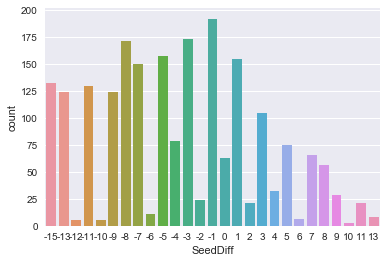

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.countplot(games.loc[(games.Pred==1)]['SeedDiff'])

In [12]:
rates = {}
for i in games['SeedDiff'].unique():
    bunsi = games.loc[(games.SeedDiff==i) & (games.Pred==1)].shape[0]
    bunbo = games.loc[(games.SeedDiff==i)].shape[0]
    if bunbo!=0:
        rate = bunsi/bunbo
    else:
        rate = 0.5
    rates[i] = rate
    print("diff {}: {}/{} = {}".format(i, bunsi, bunbo, rate))
games['rate'] = games['SeedDiff'].apply(lambda x: rates[x])
games.head()

diff 1: 155/347 = 0.44668587896253603
diff 5: 75/232 = 0.3232758620689655
diff -15: 132/132 = 1.0
diff -11: 130/151 = 0.8609271523178808
diff 7: 66/216 = 0.3055555555555556
diff -7: 150/216 = 0.6944444444444444
diff 9: 29/153 = 0.1895424836601307
diff 13: 8/132 = 0.06060606060606061
diff -3: 173/278 = 0.6223021582733813
diff 15: 0/132 = 0.0
diff -1: 192/347 = 0.553314121037464
diff -5: 157/232 = 0.6767241379310345
diff -13: 124/132 = 0.9393939393939394
diff -9: 124/153 = 0.8104575163398693
diff 3: 105/278 = 0.3776978417266187
diff 8: 56/227 = 0.24669603524229075
diff -8: 171/227 = 0.7533039647577092
diff 4: 32/111 = 0.2882882882882883
diff 11: 21/151 = 0.1390728476821192
diff 2: 21/45 = 0.4666666666666667
diff -6: 11/17 = 0.6470588235294118
diff 0: 63/126 = 0.5
diff -4: 79/111 = 0.7117117117117117
diff 6: 6/17 = 0.35294117647058826
diff -10: 5/8 = 0.625
diff 12: 0/5 = 0.0
diff -2: 24/45 = 0.5333333333333333
diff 10: 3/8 = 0.375
diff -12: 5/5 = 1.0


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,ID,IDTeams,Team1,Team2,IDTeam1,IDTeam2,Team1Seed,Team2Seed,Pred,SeedDiff,rate
0,1985,136,1116,63,1234,54,N,0,1985_1116_1234,1116_1234,1116,1234,1985_1116,1985_1234,9,8,1.0,1,0.446686
1,1985,136,1120,59,1345,58,N,0,1985_1120_1345,1120_1345,1120,1345,1985_1120,1985_1345,11,6,1.0,5,0.323276
2,1985,136,1207,68,1250,43,N,0,1985_1207_1250,1207_1250,1207,1250,1985_1207,1985_1250,1,16,1.0,-15,1.000000
3,1985,136,1229,58,1425,55,N,0,1985_1229_1425,1229_1425,1229,1425,1985_1229,1985_1425,9,8,1.0,1,0.446686
4,1985,136,1242,49,1325,38,N,0,1985_1242_1325,1242_1325,1242,1325,1985_1242,1985_1325,3,14,1.0,-11,0.860927


In [13]:
sub = datafiles['SampleSubmissionStage1']
sub['WLoc'] = 3  # N
sub['SecondaryTourney'] = 6  # NCAA
sub['Season'] = sub['ID'].map(lambda x: x.split('_')[0])
sub['Season'] = sub['ID'].map(lambda x: x.split('_')[0])
sub['Team1'] = sub['ID'].map(lambda x: x.split('_')[1])
sub['Team2'] = sub['ID'].map(lambda x: x.split('_')[2])
sub['IDTeams'] = sub.apply(lambda r: '_'.join(map(str, [r['Team1'], r['Team2']])), axis=1)
sub['IDTeam1'] = sub.apply(lambda r: '_'.join(map(str, [r['Season'], r['Team1']])), axis=1)
sub['IDTeam2'] = sub.apply(lambda r: '_'.join(map(str, [r['Season'], r['Team2']])), axis=1)
sub['Team1Seed'] = sub['IDTeam1'].map(seeds).fillna(0)
sub['Team2Seed'] = sub['IDTeam2'].map(seeds).fillna(0)
sub['SeedDiff'] = sub['Team1Seed'] - sub['Team2Seed']

In [20]:
from sklearn.linear_model import LogisticRegression
col = ['SeedDiff']
# col = ['rate']
results = []
loss = []
for season in sub['Season'].unique():
    print(season)
    x1 = games[((games['Season'] < int(season)))]
    x2 = games[((games['Season'] == int(season)))]

    reg = LogisticRegression(C=0.1)
    reg.fit(x1[col], x1['Pred'])
    pred = reg.predict(x2[col]).clip(0.05, 0.95)
    print('Log Loss:', metrics.log_loss(x2['Pred'], pred))
    loss.append(metrics.log_loss(x2['Pred'], pred))
    # test['Pred'] = reg.predict(test[col])

#     results.append(test)
# results = pd.concat(results, axis=0, ignore_index=True).reset_index(drop=True)

# Testing for Sequence of Scoring
print("Testing for Sequence of Scoring")
loss = np.mean(loss)
print('Total Log Loss:', loss)

2014
Log Loss: 1.10601770484
2015
Log Loss: 0.710496050917
2016
Log Loss: 1.04009742918
2017
Log Loss: 0.77641632657
Testing for Sequence of Scoring
Total Log Loss: 0.908256877876
